## **I. Google Colab Initializtion (Only on Colab)**

In [171]:
# from google.colab import drive
# drive.mount('/content/drive')
# cur_dir = "/content/drive/Othercomputers/My laptop/POLIMI/AN2DL/AN2DL_CH_2/Notebooks"
# %cd $cur_dir


In [172]:
#%pip install torchview

## **1. Import Libraries**

In [173]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.transforms import v2 as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchview import draw_graph

# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import cv2
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
from tqdm import tqdm
import glob
from pathlib import Path
import shutil
import torch.nn.functional as F

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


'pkill' is not recognized as an internal or external command,
operable program or batch file.


PyTorch version: 2.5.1+cu121
Device: cuda


A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file models already exists.
Error occurred while processing: models.


## **2. Preprocessing**

- Preprocessing pipeline : 
    - Get Loaded Images
    - Create Goo Masks
    - Apply Goo Removal + Resizing
    - Discard Shrek Images
    - Apply the external Masks (optional)
    

In [174]:
def _get_smart_goo_mask(img_bgr):
    """
    Internal helper to detect goo using Core & Shell logic + 1px Nudge.
    Returns a binary mask (White = Goo, Black = Safe).
    """
    # 1. Convert to HSV
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

    # 2. Define Ranges
    # CORE: Solid Green (Strict)
    core_lower = np.array([35, 100, 50])
    core_upper = np.array([85, 255, 255])
    
    # SHELL: Faint Halo (Loose/Transparent)
    shell_lower = np.array([30, 30, 30])
    shell_upper = np.array([95, 255, 255])

    # 3. Create initial masks
    mask_core = cv2.inRange(hsv, core_lower, core_upper)
    mask_shell = cv2.inRange(hsv, shell_lower, shell_upper)

    # 4. Smart Combine (Connected Components)
    # Keep 'Shell' blobs ONLY if they touch 'Core' blobs
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_shell, connectivity=8)
    smart_mask = np.zeros_like(mask_core)

    for label_id in range(1, num_labels): # Skip background (0)
        blob_mask = (labels == label_id).astype(np.uint8) * 255
        
        # Check overlap with Core
        overlap = cv2.bitwise_and(blob_mask, mask_core)
        
        # If there is ANY overlap, keep the blob
        if cv2.countNonZero(overlap) > 0:
            smart_mask = cv2.bitwise_or(smart_mask, blob_mask)

    # 5. Fill Holes (in case the goo has shiny reflections)
    contours, _ = cv2.findContours(smart_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    final_filled_mask = np.zeros_like(smart_mask)
    for contour in contours:
        # Minimum area filter (200px) to remove tiny stray noise
        if cv2.contourArea(contour) > 200:
            cv2.drawContours(final_filled_mask, [contour], -1, (255), thickness=cv2.FILLED)

    # 6. The "1-Pixel Nudge"
    # Safely expand by 1 pixel to cover the final anti-aliased fringe
    kernel = np.ones((3, 3), np.uint8)
    final_expanded_mask = cv2.dilate(final_filled_mask, kernel, iterations=1)

    return final_expanded_mask



In [175]:
def resize_batch(input_dir, output_dir, target_size=(224, 224), remove_goo=True):
    """
    Iterates through input_dir, finds 'img_xxxx', resizes them to target_size, 
    and saves the result to output_dir.
    If remove_goo is True, it subtracts green pixels (using Smart Core/Shell logic).
    """
    input_dir = Path(input_dir)
    output_dir = Path(output_dir)
    
    # Create output directory if it doesn't exist
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Extensions to look for
    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}
    
    # 1. Gather all valid image files first
    print(f"Scanning for images in: {input_dir}...")
    image_files = [
        f for f in input_dir.iterdir() 
        if f.name.startswith('img_') and f.suffix.lower() in valid_extensions
    ]
    
    if not image_files:
        print("No images found starting with 'img_' in the directory.")
        return

    # 2. Iterate with tqdm
    count = 0
    
    for file_path in tqdm(image_files, desc="Resizing Images", unit="img"):
        output_path = output_dir / file_path.name
        
        if output_path.exists():
            # Skip silently
            continue

        img = cv2.imread(str(file_path))
        if img is None:
            continue
            
        if target_size is not None:
            img = cv2.resize(img, target_size)
            
        if remove_goo:
            # --- NEW SMART GOO LOGIC ---
            # Get the smart mask (White = Goo)
            goo_mask = _get_smart_goo_mask(img)
            
            # Invert Goo Mask (White = Safe)
            not_goo_mask = cv2.bitwise_not(goo_mask)
            
            # Apply Mask
            img = cv2.bitwise_and(img, img, mask=not_goo_mask)
            
        cv2.imwrite(str(output_path), img)
        count += 1

    print(f"Resizing complete. Processed {count} new images.")

In [176]:
def apply_mask(image_path, mask_path, output_path, target_size=(224, 224), remove_goo=True):
    """
    Loads an image and a mask. 
    If remove_goo is True, it subtracts green pixels (using Smart Core/Shell logic) 
    from the valid mask area. Resizes and saves the result.
    """
    # 1. Load Image
    img = cv2.imread(str(image_path))
    if img is None:
        tqdm.write(f"Error: Could not load image at {image_path}")
        return

    # 2. Load External Mask (Read as grayscale)
    mask = cv2.imread(str(mask_path), 0)
    if mask is None:
        tqdm.write(f"Error: Could not load mask at {mask_path}")
        return

    # 3. Resize both to target size
    if target_size is not None:
        img = cv2.resize(img, target_size)
        mask = cv2.resize(mask, target_size)

    # 4. Standardize External Mask (Binary 0 or 255)
    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    # 5. Determine Final Mask
    if remove_goo:
        # --- NEW SMART GOO LOGIC ---
        # Get the smart mask (White = Goo)
        goo_mask = _get_smart_goo_mask(img)
        
        # Invert Goo Mask (White = Safe)
        not_goo_mask = cv2.bitwise_not(goo_mask)
        
        # Combine: Must be Tissue (binary_mask) AND Safe (not_goo_mask)
        final_mask = cv2.bitwise_and(binary_mask, not_goo_mask)
    else:
        # --- ORIGINAL LOGIC ---
        final_mask = binary_mask

    # 6. Apply Final Mask
    # Areas outside the final mask become Black (0)
    masked_img = cv2.bitwise_and(img, img, mask=final_mask)

    # 7. Save result
    # Ensure output directory exists
    os.makedirs(os.path.dirname(str(output_path)), exist_ok=True)
    cv2.imwrite(str(output_path), masked_img)

In [177]:
def filter_bright_green_areas(image, lg_H=20, lg_S=45, lg_V=0, ug_H=84, ug_S=255, ug_V=255, dilate_iterations=2):
    """
    Filters out bright green areas from the input image with improved residual removal.
    
    Args:
        image: Input image in RGB format (0-1 range)
        lg_H, lg_S, lg_V: Lower bounds for HSV green detection
        ug_H, ug_S, ug_V: Upper bounds for HSV green detection
        dilate_iterations: Number of dilation iterations to expand mask (removes edge artifacts)
    """

    # Convert from RGB (0-1) to BGR (0-255) for OpenCV
    original_bgr = (image * 255).astype(np.uint8)[..., ::-1]

    # 1. Convert to HSV (Hue, Saturation, Value)
    hsv = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2HSV)

    # 2. Define the "Bright Green" Range
    lower_green = (lg_H, lg_S, lg_V)
    upper_green = (ug_H, ug_S, ug_V)

    # Create the initial mask
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # 3. Morphological operations to clean up the mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

    # OPEN: Remove small noise
    clean_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)

    # DILATE: Expand the mask to catch edge artifacts and residuals
    # This ensures we remove green pixels at the boundaries
    if dilate_iterations > 0:
        clean_mask = cv2.dilate(clean_mask, kernel, iterations=dilate_iterations)

    # 4. Additional step: Detect any remaining green-ish pixels
    # Create a more aggressive mask for subtle green tones
    lower_green_subtle = (max(0, lg_H - 10), max(0, lg_S - 10), 0)
    upper_green_subtle = (min(180, ug_H + 10), 255, 255)
    subtle_mask = cv2.inRange(hsv, lower_green_subtle, upper_green_subtle)
    
    # Only keep subtle green pixels that are near the main green area
    subtle_mask = cv2.morphologyEx(subtle_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    
    # Combine masks
    combined_mask = cv2.bitwise_or(clean_mask, subtle_mask)

    # 5. Invert mask to keep the useful parts
    mask_inv = cv2.bitwise_not(combined_mask)

    # 6. Apply the mask
    result_bgr = cv2.bitwise_and(original_bgr, original_bgr, mask=mask_inv)

    return result_bgr, combined_mask

In [178]:
def analyze_dataset_for_shreks(directory, ratio_threshold=0.0125):
    shrek_images = []
    tissue_images = []
    
    image_files = glob.glob(os.path.join(directory, 'img_*.png'))
    print(f"Found {len(image_files)} images in {directory}")

    for f in image_files:
        try:
            # Load image (BGR)
            img = cv2.imread(f)
            if img is None: continue
            
            # Prepare image for the new filter: Convert BGR to RGB (0-1 float)
            img_rgb_norm = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
            
            # Apply Filter
            result_bgr, mask = filter_bright_green_areas(img_rgb_norm)
            
            # Calculate Ratio of Green Pixels from the combined mask
            total_pixels = img.shape[0] * img.shape[1]
            green_pixels = np.count_nonzero(mask)
            ratio = green_pixels / total_pixels
            
            # Convert BGR to RGB for plotting
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            entry = {
                'name': os.path.basename(f), 
                'path': f,
                'img': img_rgb, 
                'ratio': ratio,
                'mask': mask
            }

            # === CLASSIFICATION LOGIC ===
            if ratio > ratio_threshold:
                shrek_images.append(entry)
            else:
                tissue_images.append(entry)
                
        except Exception as e:
            print(f"Skipping {f}: {e}")

    return shrek_images, tissue_images

In [179]:
def process_batch(input_dir, output_dir, target_size=(224, 224), remove_goo=True):
    """
    Iterates through input_dir, finds pairs of 'img_xxxx' and 'mask_xxxx'.
    Passes the remove_goo flag to the apply_mask function.
    """
    input_dir = Path(input_dir)
    output_dir = Path(output_dir)
    
    output_dir.mkdir(parents=True, exist_ok=True)
    
    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}
    
    print(f"Scanning for images in: {input_dir}...")
    image_files = [
        f for f in input_dir.iterdir() 
        if f.name.startswith('img_') and f.suffix.lower() in valid_extensions
    ]
    
    if not image_files:
        print("No images found starting with 'img_' in the directory.")
        return

    count = 0
    
    for file_path in tqdm(image_files, desc="Processing Images", unit="img"):
        # Construct mask filename
        mask_name = file_path.name.replace('img_', 'mask_', 1)
        mask_path = input_dir / mask_name
        
        if not mask_path.exists():
            mask_stem = file_path.stem.replace('img_', 'mask_', 1)
            mask_path = input_dir / (mask_stem + ".png")
        
        if mask_path.exists():
            output_path = output_dir / file_path.name
            
            if output_path.exists():
                continue

            # Pass the remove_goo flag here
            apply_mask(file_path, mask_path, output_path, target_size=target_size, remove_goo=remove_goo)
            count += 1
        else:
            tqdm.write(f"Skipping {file_path.name}: No matching mask found.")

    print(f"Batch processing complete. Processed {count} new images.")



In [180]:
def process_classification_results(shrek_list, tissue_list, shrek_dir, tissue_dir, threshold):
    """
    Saves classified images to respective directories and visualizes the results.
    
    Args:
        shrek_list (list): List of dicts containing Shrek image data.
        tissue_list (list): List of dicts containing Tissue image data.
        shrek_dir (str): Path to save Shrek images.
        tissue_dir (str): Path to save Tissue images.
        threshold (float): The green ratio threshold used for classification.
    """
    
    # 1. Print Summary
    print(f"Classified {len(shrek_list)} as Shrek")
    print(f"Classified {len(tissue_list)} as Tissue")

    # Ensure directories exist
    os.makedirs(shrek_dir, exist_ok=True)
    os.makedirs(tissue_dir, exist_ok=True)

    # 2. Save Shrek images
    print(f"Saving {len(shrek_list)} Shrek images to {shrek_dir}...")
    for item in shrek_list:
        dest_path = os.path.join(shrek_dir, item['name'])
        
        # Check if file exists to prevent overwriting
        if os.path.exists(dest_path):
            continue

        try:
            shutil.copy2(item['path'], dest_path)
        except Exception as e:
            print(f"Error copying {item['name']} to shrek folder: {e}")

    # 3. Save Tissue images
    print(f"Saving {len(tissue_list)} Tissue images to {tissue_dir}...")
    for item in tissue_list:
        dest_path = os.path.join(tissue_dir, item['name'])
        
        # Check if file exists to prevent overwriting
        if os.path.exists(dest_path):
            continue

        try:
            shutil.copy2(item['path'], dest_path)
        except Exception as e:
            print(f"Error copying {item['name']} to tissue folder: {e}")

    # 4. Visualize Examples (2x2 Grid)
    if len(shrek_list) >= 2 and len(tissue_list) >= 2:
        fig_ex, axes = plt.subplots(2, 2, figsize=(12, 10))
        fig_ex.suptitle(f"Classification Results (Threshold: {threshold:.1%})", fontsize=16)

        def show_img(ax, item, label):
            ax.imshow(item['img'])
            # Show the Green Ratio in the title so you can see WHY it was classified
            ax.set_title(f"{label}\n{item['name']}\nGreen Pixels: {item['ratio']:.2%}")
            ax.axis('off')

        # Row 1: Detected Shrek
        show_img(axes[0, 0], shrek_list[0], "Detected Shrek")
        show_img(axes[0, 1], shrek_list[1], "Detected Shrek")
        
        # Row 2: Detected Tissue
        show_img(axes[1, 0], tissue_list[0], "Detected Tissue")
        show_img(axes[1, 1], tissue_list[1], "Detected Tissue")

        plt.tight_layout()
        plt.show()
    else:
        print("Not enough images in one or both classes to generate 2x2 sample grid.")

    # 5. Plot Scatter Distribution for Tuning
    shrek_ratios = [x['ratio'] for x in shrek_list]
    tissue_ratios = [x['ratio'] for x in tissue_list]

    plt.figure(figsize=(12, 6))

    # Plot Tissue points (Blue)
    plt.scatter(range(len(tissue_ratios)), tissue_ratios, color='blue', alpha=0.6, label='Classified as Tissue')

    # Plot Shrek points (Green) - Shifted on x-axis to be distinct
    # We shift the x-axis index for Shrek so they appear after the tissue points
    plt.scatter(range(len(tissue_ratios), len(tissue_ratios) + len(shrek_ratios)), shrek_ratios, color='green', alpha=0.6, label='Classified as Shrek')

    # Draw the Threshold Line
    plt.axhline(y=threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold ({threshold:.1%})')

    plt.title('Green Pixel Ratio per Image', fontsize=14)
    plt.ylabel('Ratio of Green Pixels (0.0 - 1.0)')
    plt.xlabel('Image Index')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# --- Example Usage ---
# shrek_list, tissue_list = analyze_dataset(DATASET_PATH) # Assuming this runs before
# process_classification_results(shrek_list, tissue_list, SHREK_DIR, TISSUE_DIR, RATIO_THRESHOLD)

In [181]:
def copy_masks(image_list, masks_dir, output_dir):
    image_names = [item['name'] for item in image_list]
    mask_names = [name.replace('img_', 'mask_', 1) for name in image_names]

    for mask_name in mask_names:
        src_path = os.path.join(masks_dir, mask_name)
        dst_path = os.path.join(output_dir, mask_name)
        shutil.copy(src_path, dst_path)
    
    return 



In [182]:
datasets_path = os.path.join(os.path.pardir, "an2dl2526c2")

train_data_path = os.path.join(datasets_path, "train_data")
train_labels_path = os.path.join(datasets_path, "train_labels.csv")
test_data_path = os.path.join(datasets_path, "test_data")

CSV_PATH = train_labels_path                # Path to the CSV file with labels
SOURCE_FOLDER = train_data_path

print(f"Dataset path: {datasets_path}")
print(f"Train data path: {train_data_path}")
print(f"Train labels path: {train_labels_path}")
print(f"Test data path: {test_data_path}")
# preprocessing output paths
#preprocessing step 1 output path
GOO_REMOVAL_OUT = os.path.join(datasets_path, "train_nogoo")

#preprocessing step 2 output path
SHREK_REMOVAL_OUT = os.path.join(datasets_path, "train_noshreks")
SHREKS_OUT = os.path.join(SHREK_REMOVAL_OUT, "train_shreks")
TISSUE_OUT = os.path.join(SHREK_REMOVAL_OUT, "train_tissue")

#preprocessing step 3 output path
FINAL_TRAIN_OUT = os.path.join(datasets_path, "train_masked_noshreks")
  # Where the resized unmasked images will be saved

TARGET_SIZE = (224, 224)                    # Target size for the resized images and masks

Dataset path: ..\an2dl2526c2
Train data path: ..\an2dl2526c2\train_data
Train labels path: ..\an2dl2526c2\train_labels.csv
Test data path: ..\an2dl2526c2\test_data


Scanning for images in: ..\an2dl2526c2\train_data...


Resizing Images: 100%|██████████| 1412/1412 [00:00<00:00, 24423.50img/s]


Resizing complete. Processed 0 new images.
Found 1412 images in ..\an2dl2526c2\train_nogoo
Classified 150 as Shrek
Classified 1262 as Tissue
Saving 150 Shrek images to ..\an2dl2526c2\train_noshreks\train_shreks...
Saving 1262 Tissue images to ..\an2dl2526c2\train_noshreks\train_tissue...


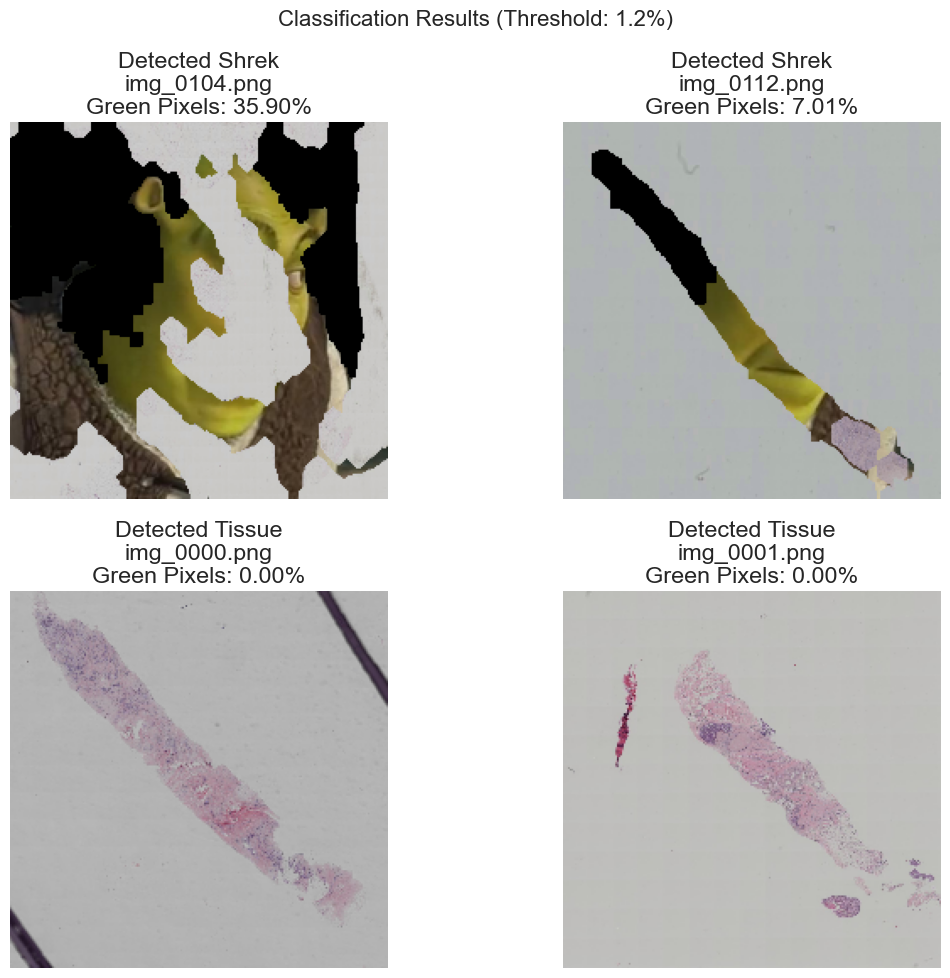

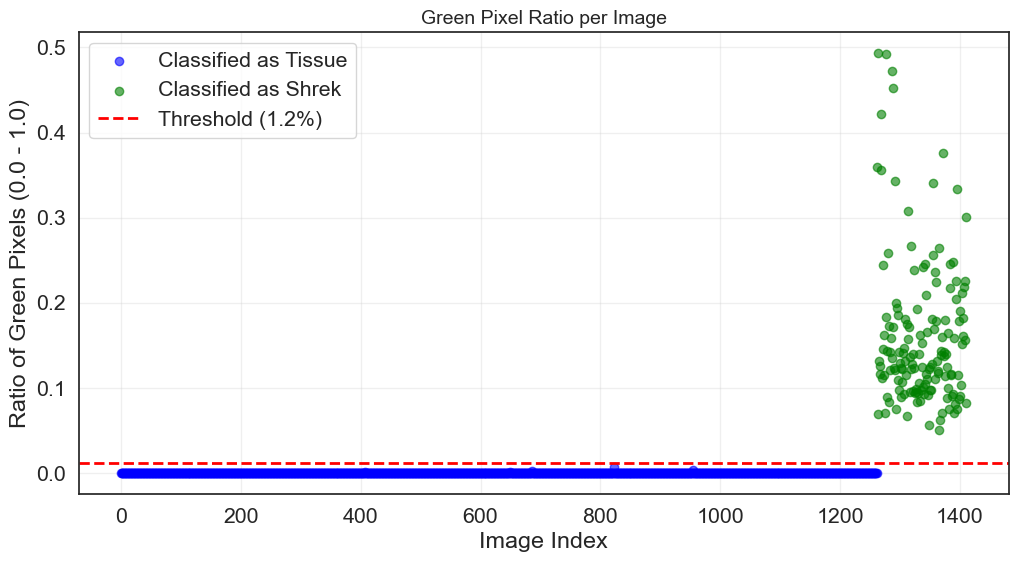

Scanning for images in: ..\an2dl2526c2\train_noshreks\train_tissue...


Processing Images: 100%|██████████| 1262/1262 [00:00<00:00, 12222.81img/s]

Batch processing complete. Processed 0 new images.


In [183]:
# Step 1: Remove goo and resize images
resize_batch(SOURCE_FOLDER,GOO_REMOVAL_OUT, target_size=TARGET_SIZE, remove_goo=True)

#Step 2: Discard Shrek Images
shreks_list, tissue_list = analyze_dataset_for_shreks(GOO_REMOVAL_OUT, ratio_threshold=0.0125)
process_classification_results(shreks_list, tissue_list, SHREKS_OUT, TISSUE_OUT, 0.0125)

#Step 3 : Apply the external masks
copy_masks(tissue_list, SOURCE_FOLDER, TISSUE_OUT)
copy_masks(shreks_list, SOURCE_FOLDER, SHREKS_OUT)
process_batch(TISSUE_OUT, FINAL_TRAIN_OUT, target_size=TARGET_SIZE, remove_goo=False)



## **3. Load Images From Folder**

In [184]:
def load_images_from_folder(folder, resize=None, filter_prefix=None):
    """
    Load and preprocess images from a specified folder with a progress bar.

    Args:
        folder (str): Path to the folder containing images
        resize (tuple): Target size (width, height) or None
        filter_prefix (str): Prefix to filter filenames (e.g. 'img_')

    Returns:
        tuple: (np.ndarray of images, list of filenames)
    """
    images = []
    loaded_filenames = []
    
    # Get the list of files to iterate over
    file_list = sorted(os.listdir(folder))
    
    # Filter files before iterating to show correct progress
    if filter_prefix:
        file_list = [f for f in file_list if f.startswith(filter_prefix)]

    # Iterate through files with a tqdm progress bar
    for filename in tqdm(file_list, desc=f"Loading images from {os.path.basename(folder)}"):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)

        # Check if image was loaded successfully right away
        if img is None:
            # print(f"Warning: Failed to load image at {img_path}. Skipping.")
            continue

        # Normalize image pixel values to a float range [0, 1]
        img = (img / 255.0).astype(np.float32)

        # Convert image from BGR to RGB
        img = img[..., ::-1]

        if resize:
            img = cv2.resize(img, resize)

        images.append(img)
        loaded_filenames.append(filename)

    return np.array(images), loaded_filenames

In [185]:
# Load masked images (already resized in process_batch)
# We add filter_prefix='img_' to ensure we don't load any mask files that might be in the folder
masked_images, masked_filenames = load_images_from_folder(FINAL_TRAIN_OUT, filter_prefix='img_')

train_images = masked_images

filenames = masked_filenames


print(f"Loaded {len(masked_images)} masked images.")
print(f"Total images: {len(train_images)}")

Loading images from train_masked_noshreks: 100%|██████████| 1262/1262 [00:00<00:00, 1423.68it/s]


Loaded 1262 masked images.
Total images: 1262


## **4. Exploration and Data Analysis**

## 4.1 Check Applied Masks

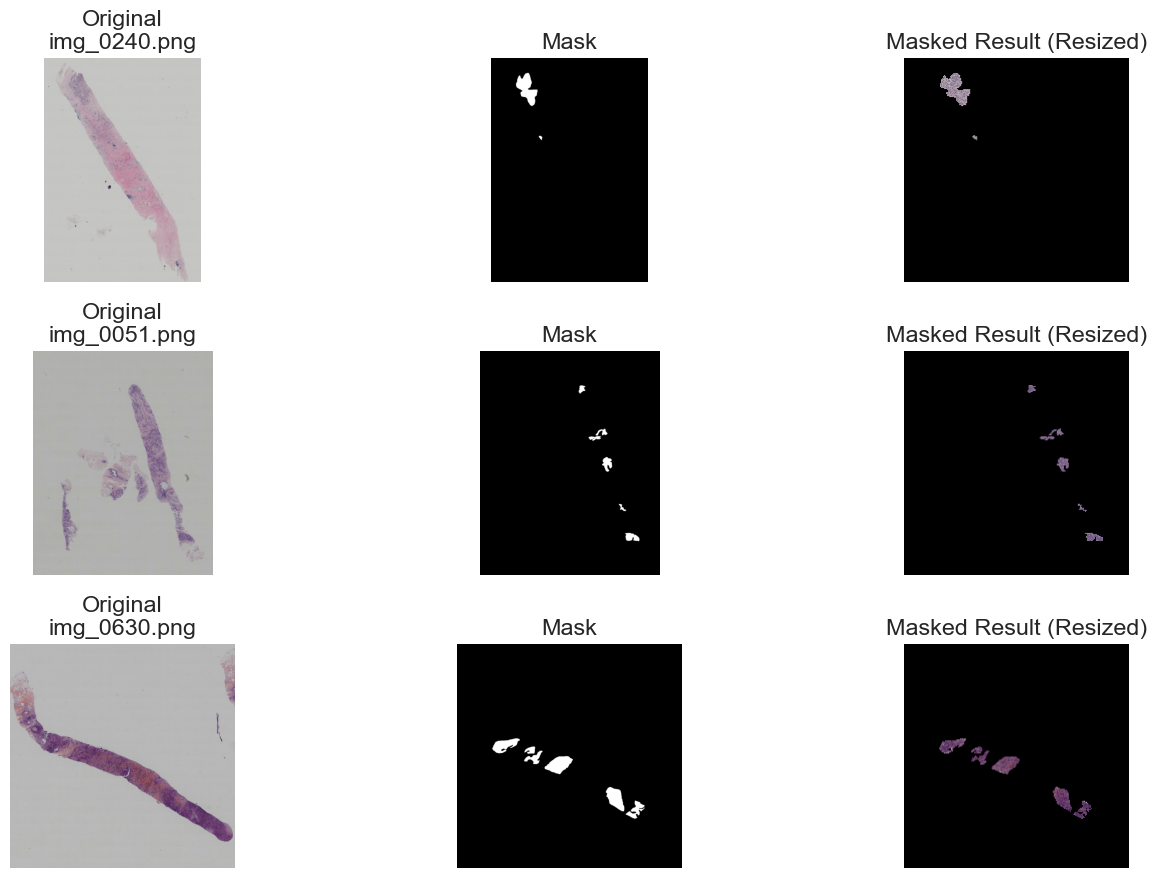

In [186]:
#@ title Mask Verification
# Select a few random images from the output folder to verify the process
masked_files = os.listdir(FINAL_TRAIN_OUT)
num_samples = 3
selected_files = random.sample(masked_files, num_samples)

fig, axes = plt.subplots(num_samples, 3, figsize=(15, 3 * num_samples))

for i, filename in enumerate(selected_files):
    # 1. Define paths
    masked_image_path = os.path.join(FINAL_TRAIN_OUT, filename)
    original_image_path = os.path.join(SOURCE_FOLDER, filename)
    
    # Logic to find the mask path (replicating logic from Cell 5)
    mask_name = filename.replace('img_', 'mask_', 1)
    mask_path = os.path.join(SOURCE_FOLDER, mask_name)
    
    # Check if mask exists, if not try .png fallback as per Cell 5 logic
    if not os.path.exists(mask_path):
        mask_stem = os.path.splitext(filename)[0].replace('img_', 'mask_', 1)
        mask_path = os.path.join(SOURCE_FOLDER, mask_stem + ".png")

    # 2. Load images
    # Original
    orig_img = cv2.imread(original_image_path)
    if orig_img is not None:
        orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    # Mask
    mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    # Masked (Result)
    masked_img = cv2.imread(masked_image_path)
    if masked_img is not None:
        masked_img = cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB)

    # 3. Plot
    # Original
    if orig_img is not None:
        axes[i, 0].imshow(orig_img)
        axes[i, 0].set_title(f"Original\n{filename}")
    else:
        axes[i, 0].text(0.5, 0.5, "Original Not Found", ha='center')
    axes[i, 0].axis('off')

    # Mask
    if mask_img is not None:
        axes[i, 1].imshow(mask_img, cmap='gray')
        axes[i, 1].set_title(f"Mask")
    else:
        axes[i, 1].text(0.5, 0.5, "Mask Not Found", ha='center')
    axes[i, 1].axis('off')

    # Masked
    if masked_img is not None:
        axes[i, 2].imshow(masked_img)
        axes[i, 2].set_title(f"Masked Result (Resized)")
    else:
        axes[i, 2].text(0.5, 0.5, "Result Not Found", ha='center')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

### 3.1 Show Some Random Images

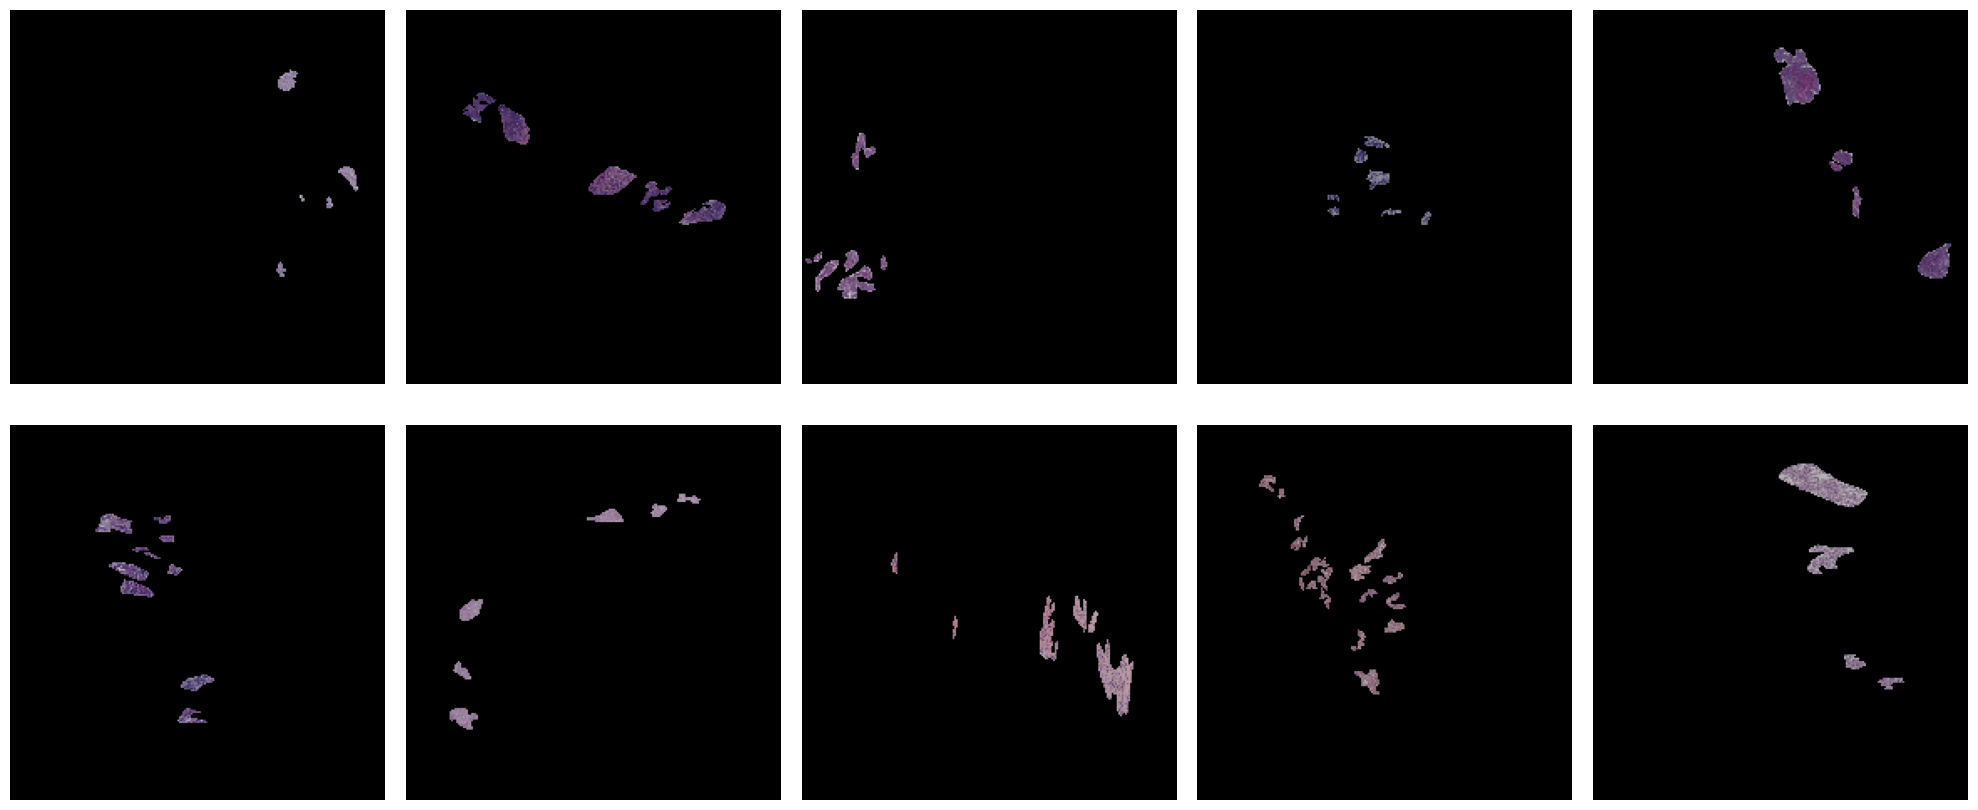

In [187]:
# Number of images to display
num_img = 10
# Starting index
start_img= random.randint(0, len(train_images) - num_img)
# Create subplots for displaying items
fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
for i in range(start_img, start_img+num_img):
    ax = axes[i%2, i%num_img//2]
    ax.imshow(np.clip(train_images[i], 0, 1))  # Display clipped item images
    ax.axis('off')
plt.tight_layout()
plt.show()



## **5. Train/Val Split**

In [188]:
from sklearn.preprocessing import LabelEncoder

# 1. Load the labels CSV
labels_df = pd.read_csv(train_labels_path)
# Create a dictionary mapping filename -> label for fast lookup
labels_map = dict(zip(labels_df.iloc[:, 0], labels_df.iloc[:, 1]))

# 2. Get the filenames corresponding to the images loaded in Cell 7
# IMPORTANT: This must match the order used in 'load_images_from_folder' exactly.
# We use the filenames list created in the previous cell.
# filenames = os.listdir(MASKED_IMAGE_PATH)

print("Aligning labels to loaded images...")

X_aligned = []
y_aligned = []

# 3. Iterate through the filenames to sync X (images) and y (labels)
# We assume 'train_images' matches the order of 'filenames' because they rely on the same os.listdir call order
# provided no files were added/deleted between Cell 7 and Cell 9.
if len(filenames) != len(train_images):
    raise ValueError(f"Mismatch! Loaded images ({len(train_images)}) != Files found ({len(filenames)}).")

for i, filename in enumerate(filenames):
    if filename in labels_map:
        # If the file exists in our CSV, keep the image and the label
        X_aligned.append(train_images[i])
        y_aligned.append(labels_map[filename])
    else:
        # If image is in folder but NOT in CSV, we must discard the image
        print(f"Skipping {filename}: Image found but no label in CSV.")

# Convert to numpy arrays
X = np.array(X_aligned)
y = np.array(y_aligned)

print(f"Images aligned: {X.shape}")
print(f"Labels aligned: {y.shape}")

# 4. Encode labels (String -> Integer)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Print class mapping
print("Classes:", label_encoder.classes_)
unique_labels = label_encoder.classes_

# 5. Train-Test Split (Stratified)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, 
    test_size=0.2, 
    random_state=SEED, 
    stratify=y_encoded
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=SEED,
    stratify=y_temp
)

print(f"Training data shape: {X_train.shape}, Labels: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Labels: {y_val.shape}")
print(f"Test data shape: {X_test.shape}, Labels: {y_test.shape}")

Aligning labels to loaded images...
Images aligned: (1262, 224, 224, 3)
Labels aligned: (1262,)
Classes: ['HER2(+)' 'Luminal A' 'Luminal B' 'Triple negative']
Training data shape: (1009, 224, 224, 3), Labels: (1009,)
Validation data shape: (126, 224, 224, 3), Labels: (126,)
Test data shape: (127, 224, 224, 3), Labels: (127,)


### 4.1 Set Input Size and Number of Classes

In [189]:
# Define the input shape based on the training data
input_shape = (X_train.shape[3], X_train.shape[1], X_train.shape[2])

# Define the number of classes
num_classes = len(np.unique(y_train))

print("Input Shape:", input_shape)
print("Number of Classes:", num_classes)

Input Shape: (3, 224, 224)
Number of Classes: 4


### 4.2 Create Tensor Datasets

In [190]:
# Convert numpy arrays to PyTorch datasets (without augmentation for now)
train_ds = TensorDataset(
    torch.from_numpy(X_train).permute(0, 3, 1, 2),
    torch.from_numpy(y_train).squeeze().long()
)
val_ds = TensorDataset(
    torch.from_numpy(X_val).permute(0, 3, 1, 2),
    torch.from_numpy(y_val).squeeze().long()
)
test_ds = TensorDataset(
    torch.from_numpy(X_test).permute(0, 3, 1, 2),
    torch.from_numpy(y_test).squeeze().long()
)

## **6. Dataloaders**

### 6.1 Set Batch Size

In [191]:
# Define the batch size
BATCH_SIZE = 32

### 6.2 make_loader Function Definition

In [192]:
def make_loader(ds, batch_size, shuffle, drop_last):
    """
    Create a PyTorch DataLoader with optimized settings.

    Args:
        ds (Dataset): PyTorch Dataset object
        batch_size (int): Number of samples per batch
        shuffle (bool): Whether to shuffle data at each epoch
        drop_last (bool): Whether to drop last incomplete batch

    Returns:
        DataLoader: Configured DataLoader instance
    """
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

### 6.3 Create Data Loaders

In [193]:
# Create data loaders with different settings for each phase
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [194]:
# Get one batch from the training data loader
for xb, yb in train_loader:
    print("Features batch shape:", xb.shape)
    print("Labels batch shape:", yb.shape)
    break  # Stop after getting one batch

Features batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


##  **7. Network Parameters**

In [195]:
# Number of training epochs
LEARNING_RATE = 1e-3
EPOCHS = 1000
PATIENCE = 10

# Regularisation
DROPOUT_RATE = 0.2         # Dropout probability
L1_LAMBDA = 0            # L1 penalty
L2_LAMBDA = 1e-4            # L2 penalty

# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Print the defined parameters
print("Epochs:", EPOCHS)
print("Batch Size:", BATCH_SIZE)
print("Learning Rare:", LEARNING_RATE)
print("Dropout Rate:", DROPOUT_RATE)
print("L1 Penalty:", L1_LAMBDA)
print("L2 Penalty:", L2_LAMBDA)

Epochs: 1000
Batch Size: 32
Learning Rare: 0.001
Dropout Rate: 0.2
L1 Penalty: 0
L2 Penalty: 0.0001


## **8. Simple CNN**

In [196]:
# CNN Architecture parameters
# Number of convolutional blocks
NUM_BLOCKS = 2

# Number of conv layers per block
CONVS_PER_BLOCK = 1

# Use strided convolutions instead of pooling
USE_STRIDE = False

# Stride value when USE_STRIDE is True
STRIDE_VALUE = 2

# Padding size
PADDING_SIZE = 1

# Pooling size when USE_STRIDE is False
POOL_SIZE = 2

# Number of channels in first block
INITIAL_CHANNELS = 32

# Channel multiplication factor between blocks
CHANNEL_MULTIPLIER = 2

print("Num Blocks:", NUM_BLOCKS)
print("Convs per Block:", CONVS_PER_BLOCK)
print("Use Stride:", USE_STRIDE)
print("Stride Value:", STRIDE_VALUE)
print("Padding Size:", PADDING_SIZE)
print("Pool Size:", POOL_SIZE)
print("Initial Channels:", INITIAL_CHANNELS)
print("Channel Multiplier:", CHANNEL_MULTIPLIER)

# Initialize configuration for convolutional layers
stack = 2
blocks = 5
filters = 32
kernel_size = 3

Num Blocks: 2
Convs per Block: 1
Use Stride: False
Stride Value: 2
Padding Size: 1
Pool Size: 2
Initial Channels: 32
Channel Multiplier: 2


In [197]:
class BasicCNNBlock(nn.Module):
    """A foundational CNN block: Convolutional layer -> ReLU activation -> Max Pooling.

    This block is typical in early CNN architectures like AlexNet, combining feature extraction,
    non-linear activation, and dimensionality reduction.
    """

    def __init__(self, in_channels, filters, kernel_size=3, stack=2):
        """Initialises the BasicCNNBlock.

        Args:
            in_channels (int): Number of input channels.
            filters (int): Number of output filters (channels) for each convolutional layer.
            kernel_size (int, optional): Size of the convolutional kernel. Defaults to 3.
            stack (int, optional): Number of Conv-ReLU layers before pooling. Defaults to 2.
        """
        super().__init__()

        layers_list = []
        current_channels = in_channels

        # Stack Conv-ReLU layers, preserving spatial dimensions with 'padding=same'.
        for i in range(stack):
            layers_list.append(
                nn.Conv2d(current_channels, filters, kernel_size, padding='same', bias=False) # Bias is often omitted before BatchNorm.
            )
            layers_list.append(nn.ReLU()) # Apply non-linearity.
            current_channels = filters # Update channels for the next layer.

        # MaxPool to halve spatial dimensions and provide translation robustness.
        layers_list.append(nn.MaxPool2d(2))

        self.block = nn.Sequential(*layers_list)

    def forward(self, x):
        """Defines the forward pass.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after block processing.
        """
        return self.block(x)


class BasicCNNModel(nn.Module):
    """A complete CNN model constructed from multiple BasicCNNBlocks.

    This model exemplifies a basic CNN architecture, stacking convolutional blocks,
    followed by flattening and a final dense layer for classification.
    """

    def __init__(self, input_shape, output_shape, filters=64, kernel_size=3, stack=2, blocks=3):
        """Initialises the BasicCNNModel.

        Args:
            input_shape (tuple): Shape of the input images (C, H, W).
            output_shape (int): Number of output classes.
            filters (int, optional): Initial number of filters for the first block. Defaults to 64.
            kernel_size (int, optional): Kernel size for convolutional layers. Defaults to 3.
            stack (int, optional): Number of Conv-ReLU layers per block. Defaults to 2.
            blocks (int, optional): Number of `BasicCNNBlock` instances to stack. Defaults to 3.
        """
        super().__init__()

        block_list = []
        current_channels = input_shape[0] # Input channels (e.g., 3 for RGB).
        current_filters = filters # Starting filters.

        # Create stacked blocks, typically doubling filters for each subsequent block.
        for b in range(blocks):
            block_list.append(BasicCNNBlock(
                in_channels=current_channels,
                filters=current_filters,
                kernel_size=kernel_size,
                stack=stack
            ))
            current_channels = current_filters # Output channels become input for the next block.
            current_filters *= 2 # Double filters for the next block.

        self.blocks = nn.Sequential(*block_list)

        # Dynamically calculate the flattened size for the linear layer.
        # A dummy tensor is used to determine the feature map size post-convolution.
        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape)
            dummy_out = self.blocks(dummy)
            flatten_size = dummy_out.view(1, -1).shape[1]

        self.flatten = nn.Flatten() # Flatten multi-dimensional output to 1D vector.
        self.dense = nn.Linear(flatten_size, output_shape) # Final fully connected layer.

    def forward(self, x):
        """Defines the forward pass.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output probabilities after Softmax activation.
        """
        x = self.blocks(x)
        x = self.flatten(x)
        x = self.dense(x)
        return F.softmax(x, dim=1) # Convert logits to probabilities.

In [198]:
class GAPModel(nn.Module):
    """Model using Global Average Pooling (GAP) instead of Flatten + Dense.

    This architecture replaces the traditional flattening and fully-connected layers
    with Global Average Pooling, which reduces parameters and often improves generalisation.
    """

    def __init__(self, input_shape, output_shape, filters=32, kernel_size=3,
                 stack=2, blocks=3):
        """Initialises the GAPModel.

        Args:
            input_shape (tuple): Shape of the input images (C, H, W).
            output_shape (int): Number of output classes.
            filters (int, optional): Initial number of filters for the first block. Defaults to 32.
            kernel_size (int, optional): Kernel size for convolutional layers. Defaults to 3.
            stack (int, optional): Number of Conv-ReLU layers per block. Defaults to 2.
            blocks (int, optional): Number of `BasicCNNBlock` instances to stack. Defaults to 3.
        """
        super().__init__()

        self.blocks_list = nn.ModuleList()
        current_channels = input_shape[0]
        current_filters = filters

        # Create multiple BasicCNNBlocks, doubling filters for each subsequent block.
        for b in range(blocks):
            block = BasicCNNBlock(
                in_channels=current_channels,
                filters=current_filters,
                kernel_size=kernel_size,
                stack=stack
            )
            self.blocks_list.append(block)
            current_channels = current_filters
            current_filters *= 2

        # Global Average Pooling replaces Flatten + Dense for parameter reduction.
        self.gap = nn.AdaptiveAvgPool2d(1) # Pools each feature map to a single value.
        self.flatten = nn.Flatten() # Flattens the pooled output.
        self.dense = nn.Linear(current_channels, output_shape) # Final classification layer.

    def forward(self, x):
        """Defines the forward pass.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output probabilities after Softmax activation.
        """
        for block in self.blocks_list:
            x = block(x)
        x = self.gap(x)
        x = self.flatten(x)
        x = self.dense(x)
        return F.softmax(x, dim=1) # Converts logits to probabilities.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             864
              ReLU-2         [-1, 32, 224, 224]               0
            Conv2d-3         [-1, 32, 224, 224]           9,216
              ReLU-4         [-1, 32, 224, 224]               0
         MaxPool2d-5         [-1, 32, 112, 112]               0
     BasicCNNBlock-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 64, 112, 112]          18,432
              ReLU-8         [-1, 64, 112, 112]               0
            Conv2d-9         [-1, 64, 112, 112]          36,864
             ReLU-10         [-1, 64, 112, 112]               0
        MaxPool2d-11           [-1, 64, 56, 56]               0
    BasicCNNBlock-12           [-1, 64, 56, 56]               0
           Conv2d-13          [-1, 128, 56, 56]          73,728
             ReLU-14          [-1, 128,


(process:21308): Pango-WARNING **: 02:57:25.613: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


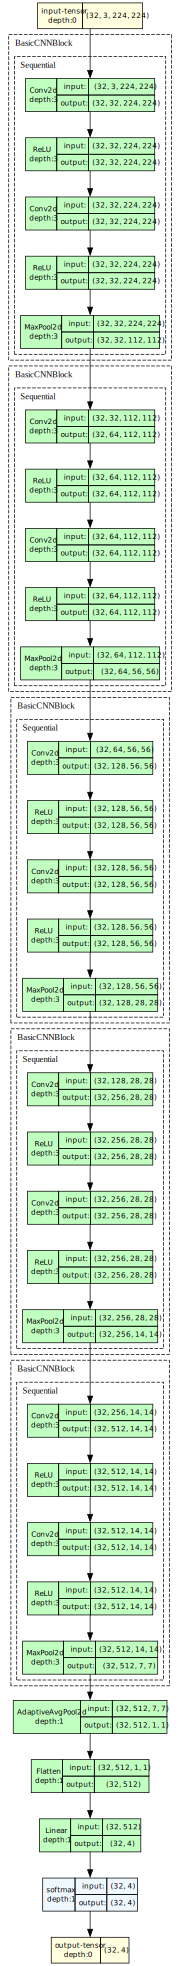

In [199]:
# Create and display the GAP model
gap_model = GAPModel(input_shape, num_classes, filters, kernel_size, stack, blocks).to(device)
summary(gap_model, input_size=input_shape)
model_graph = draw_graph(gap_model, input_size=(BATCH_SIZE,)+input_shape, expand_nested=True)
model_graph.visual_graph

In [200]:
# Set up TensorBoard logging and save model architecture
experiment_name = "gap_model"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)
x = torch.randn(1, input_shape[0], input_shape[1], input_shape[2]).to(device)
writer.add_graph(gap_model, x)

# Define optimizer with L2 regularization
optimizer = torch.optim.AdamW(gap_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

## **9. Training Loop**

In [201]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

In [202]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm


        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

In [203]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_accuracy

In [204]:
def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):
    """
    Log training metrics and model parameters to TensorBoard for visualization.

    Args:
        writer (SummaryWriter): TensorBoard SummaryWriter object for logging
        epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
        train_loss (float): Training loss for this epoch
        train_f1 (float): Training f1 score for this epoch
        val_loss (float): Validation loss for this epoch
        val_f1 (float): Validation f1 score for this epoch
        model (nn.Module): The neural network model (for logging weights/gradients)

    Note:
        This function logs scalar metrics (loss/f1 score) and histograms of model
        parameters and gradients, which helps monitor training progress and detect
        issues like vanishing/exploding gradients.
    """
    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty before adding a histogram
            if param.numel() > 0:
                writer.add_histogram(f'{name}/weights', param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty before adding a histogram
                if param.grad.numel() > 0:
                    if param.grad is not None and torch.isfinite(param.grad).all():
                        writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)

In [205]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

In [206]:
%%time
# Train model and track training history
gap_model, training_history = fit(
    model=gap_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=1,
    experiment_name="cnn",
    patience=PATIENCE
    )

# Update best model if current performance is superior
if training_history['val_f1'][-1] > best_performance:
    best_model = cnn_model
    best_performance = training_history['val_f1'][-1]

Training 1000 epochs...
Epoch   1/1000 | Train: Loss=nan, F1 Score=0.2074 | Val: Loss=nan, F1 Score=0.2188
Epoch   2/1000 | Train: Loss=nan, F1 Score=0.2114 | Val: Loss=nan, F1 Score=0.2497
Epoch   3/1000 | Train: Loss=nan, F1 Score=0.2164 | Val: Loss=nan, F1 Score=0.2497
Epoch   4/1000 | Train: Loss=nan, F1 Score=0.2246 | Val: Loss=nan, F1 Score=0.2384
Epoch   5/1000 | Train: Loss=nan, F1 Score=0.2229 | Val: Loss=nan, F1 Score=0.2384
Epoch   6/1000 | Train: Loss=nan, F1 Score=0.2229 | Val: Loss=nan, F1 Score=0.2384
Epoch   7/1000 | Train: Loss=nan, F1 Score=0.2229 | Val: Loss=nan, F1 Score=0.2384
CPU times: total: 30.6 s
Wall time: 1min 9s


ValueError: The histogram is empty, please file a bug report.

## **10. Results Analysis**

### 10.1 F1 - Loss Plot

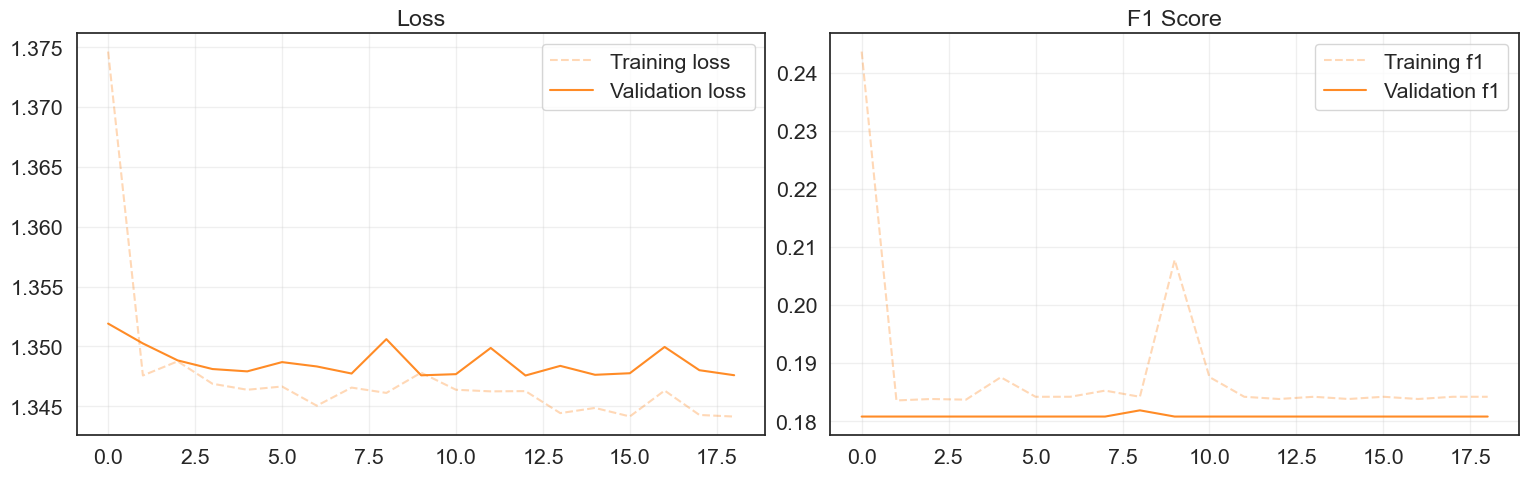

In [ ]:
# @title Plot Hitory
# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(training_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(training_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(training_history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(training_history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

### 10.2 Confusion Matrix

Accuracy over the validation set: 0.3492
Precision over the validation set: 0.1219
Recall over the validation set: 0.3492
F1 score over the validation set: 0.1808


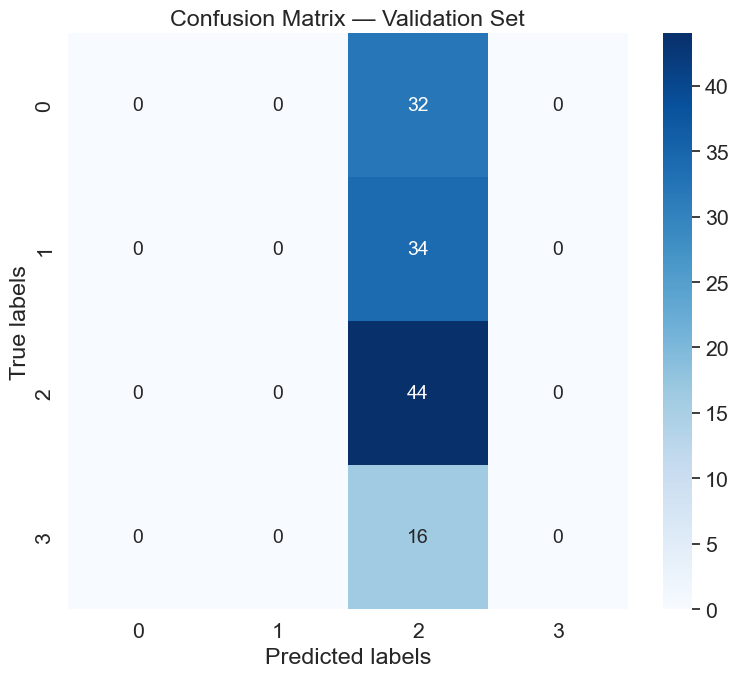

In [ ]:
# @title Plot Confusion Matrix
# Collect predictions and ground truth labels
val_preds, val_targets = [], []
with torch.no_grad():  # Disable gradient computation for inference
    for xb, yb in val_loader:
        xb = xb.to(device)

        # Forward pass: get model predictions
        logits = cnn_model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()

        # Store batch results
        val_preds.append(preds)
        val_targets.append(yb.numpy())

# Combine all batches into single arrays
val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# Calculate overall validation metrics
val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average='weighted')
val_rec = recall_score(val_targets, val_preds, average='weighted')
val_f1 = f1_score(val_targets, val_preds, average='weighted')
print(f"Accuracy over the validation set: {val_acc:.4f}")
print(f"Precision over the validation set: {val_prec:.4f}")
print(f"Recall over the validation set: {val_rec:.4f}")
print(f"F1 score over the validation set: {val_f1:.4f}")

# Generate confusion matrix for detailed error analysis
cm = confusion_matrix(val_targets, val_preds)

# Create numeric labels for heatmap annotation
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='',
            cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set')
plt.tight_layout()
plt.show()

### 10.3 Activations

In [ ]:
# @title Activation visualisation
def get_activation(name):
    """Creates a hook function to capture and store layer outputs."""
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook


def find_last_conv_layer(model):
    """
    Identifies the final Conv2D layer in the model architecture.
    """
    last_conv_name = None
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            last_conv_name = name

    if last_conv_name is None:
        raise ValueError("No Conv2D layer found in the model.")
    return last_conv_name


def visualize(model, X, y, unique_labels, num_images=50, display_activations=True, display_all_conv_layers=False):
    """
    Visualises model predictions and internal activations for a random test image.
    Uses PyTorch hooks to extract intermediate layer outputs.

    Args:
        display_all_conv_layers: If True, shows all conv layers. If False, shows only last conv of each block.
    """

    # --- 1. Select Image and Prepare Tensor ---

    # Randomly select an image from the dataset
    image_idx = np.random.randint(0, num_images)
    img_np = X[image_idx]
    label_np = y[image_idx]

    # Convert NumPy array to PyTorch tensor with correct dimensions
    # Transform from (H, W, C) to (N, C, H, W) format
    img_tensor = torch.from_numpy(img_np)
    img_tensor = img_tensor.permute(2, 0, 1)
    img_tensor = img_tensor.unsqueeze(0).to(device)

    # --- 2. Register Hooks and Make Prediction ---

    # Clear previous activations
    activations.clear()

    # Attach forward hooks to convolutional layers
    hooks = []
    conv_names = []

    # Iterate through all blocks in the features Sequential
    for block_idx, block in enumerate(model.features):
        # Find all Conv2d layers in this block
        conv_layers_in_block = []
        for layer_idx, layer in enumerate(block.block):
            if isinstance(layer, nn.Conv2d):
                conv_layers_in_block.append((layer_idx, layer))

        # Register hooks based on display_all_conv_layers flag
        if display_all_conv_layers:
            # Register hook for every Conv2d layer
            for layer_idx, conv_layer in conv_layers_in_block:
                hook_name = f'block{block_idx}_conv{layer_idx}'
                conv_names.append(hook_name)
                hooks.append(conv_layer.register_forward_hook(get_activation(hook_name)))
        else:
            # Register hook only for the last Conv2d layer in this block
            if conv_layers_in_block:
                layer_idx, conv_layer = conv_layers_in_block[-1]
                hook_name = f'block{block_idx}_conv{layer_idx}'
                conv_names.append(hook_name)
                hooks.append(conv_layer.register_forward_hook(get_activation(hook_name)))

    # Generate prediction with gradient tracking disabled
    model.eval()
    with torch.no_grad():
        logits = model(img_tensor)
        probabilities = torch.softmax(logits, dim=1)

    # Remove hooks after forward pass
    for hook in hooks:
        hook.remove()

    # Extract predicted class and confidence
    predictions = probabilities.cpu().numpy()
    class_int = np.argmax(predictions[0])
    class_str = unique_labels[class_int]

    # Extract true class (handle both one-hot encoded and integer labels)
    if label_np.ndim > 0 and len(label_np) > 1:
        # One-hot encoded
        true_class_int = np.argmax(label_np)
    else:
        # Already an integer index
        true_class_int = int(label_np)
    true_class_str = unique_labels[true_class_int]

    # --- 3. Plot Image and Prediction Bar ---

    # Create figure with custom layout
    fig = plt.figure(constrained_layout=True, figsize=(16, 4))
    gs = gridspec.GridSpec(1, 2, figure=fig, width_ratios=[1.5, 1.5], wspace=0)

    # Display original image with true label
    ax1 = fig.add_subplot(gs[0])
    ax1.set_title(f"True class: {true_class_str}", loc='left')
    if img_np.shape[-1] == 1:
        ax1.imshow(np.squeeze(img_np), cmap='bone', vmin=0., vmax=1.)
    else:
        ax1.imshow(np.squeeze(img_np), vmin=0., vmax=1.)
    ax1.axis('off')

    # Display class probability distribution
    ax2 = fig.add_subplot(gs[1])
    ax2.barh(unique_labels, np.squeeze(predictions, axis=0), color=plt.get_cmap('tab10').colors)
    ax2.set_title(f"Predicted class: {class_str} (Confidence: {max(np.squeeze(predictions[0])):.2f})", loc='left')
    ax2.grid(alpha=0.3)
    ax2.set_xlim(0.0, 1.0)
    plt.show()

    # --- 4. Plot Activations ---

    if display_activations:
        # Visualise activations for each registered layer
        for conv_name in conv_names:
            # Retrieve stored activations from hooks
            layer_activations = activations[conv_name]

            # Get number of channels
            num_channels = layer_activations.shape[1]

            # Display up to 16 feature maps per layer
            num_display = min(16, num_channels)

            # Calculate grid layout
            if num_display <= 8:
                rows, cols = 1, num_display
                figsize = (18, 3)
            else:
                rows, cols = 2, 8
                figsize = (18, 5)

            # Create subplot grid
            fig, axes = plt.subplots(rows, cols, figsize=figsize)

            # Flatten axes array for easier indexing
            if num_display > 1:
                axes = axes.flatten() if rows > 1 or cols > 1 else [axes]
            else:
                axes = [axes]

            # Plot each activation map
            for i in range(num_display):
                ax = axes[i]
                activation_map = layer_activations[0, i].cpu().numpy()
                ax.imshow(activation_map, cmap='bone', vmin=np.min(activation_map), vmax=np.max(activation_map))
                ax.axis('off')
                if i == 0:
                    ax.set_title(f'{conv_name} activations', loc='left')

            # Hide unused subplots
            for i in range(num_display, len(axes)):
                axes[i].axis('off')

            plt.tight_layout()
            plt.show()

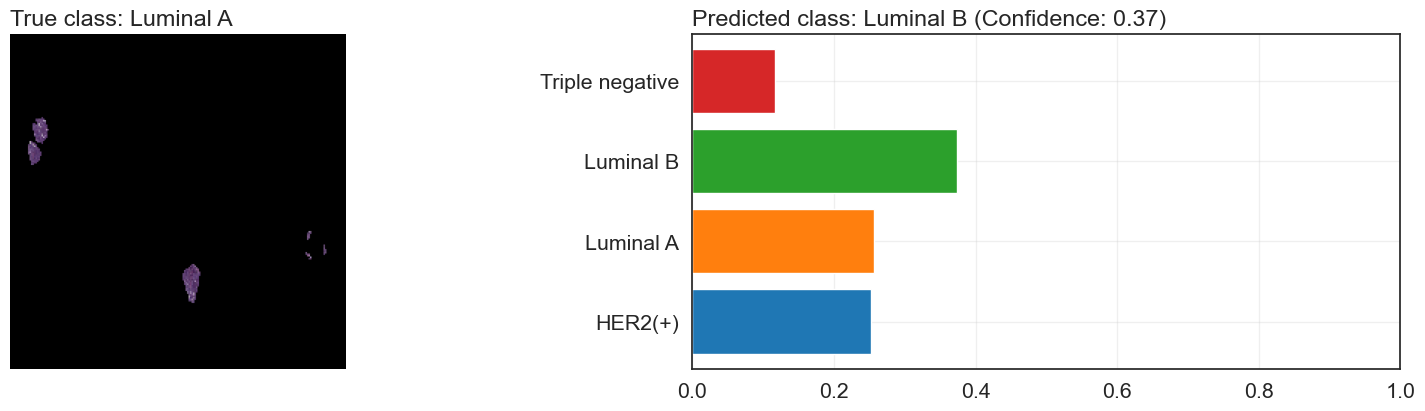

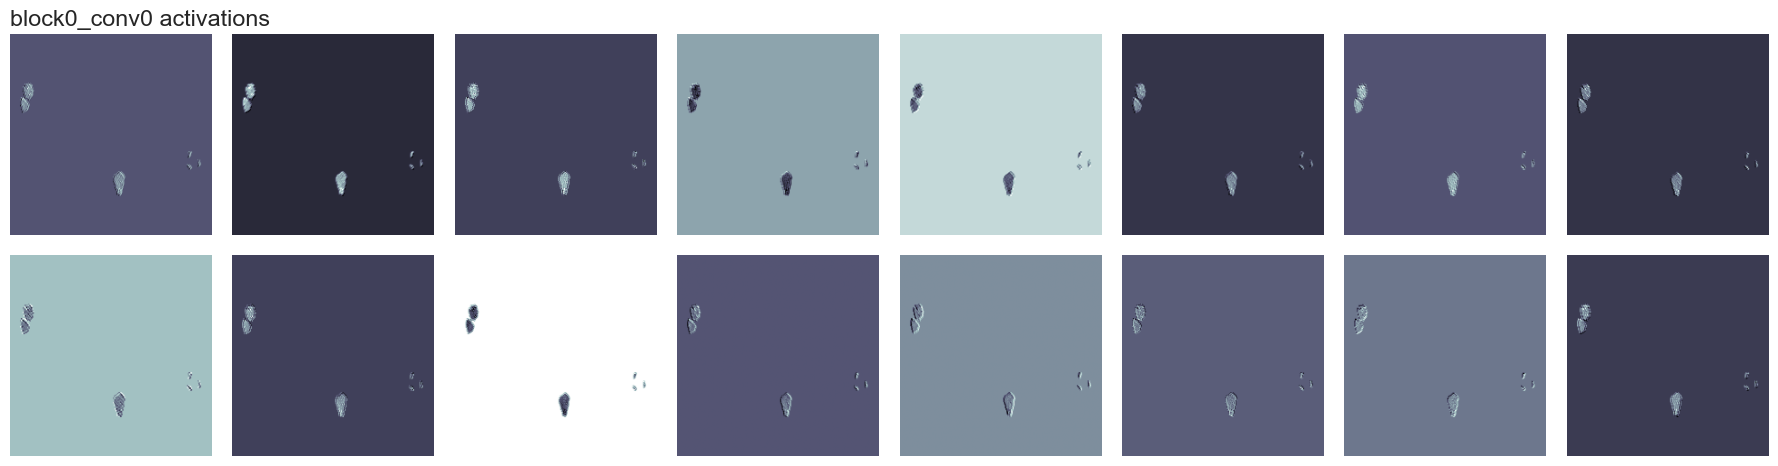

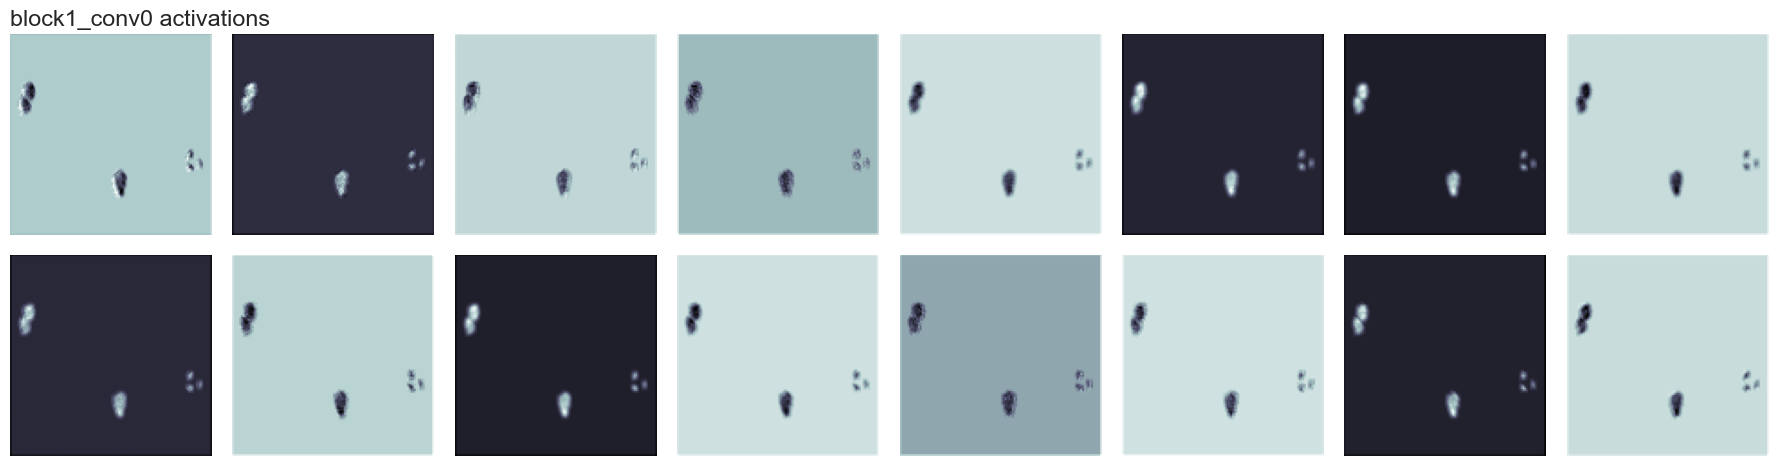

In [ ]:
# Dictionary to store layer activations via forward hooks
activations = {}
unique_labels = label_encoder.classes_
# Visualise model predictions and internal representations
# Set display_all_conv_layers=True to show all conv layers, False for only last conv of each block
visualize(cnn_model, X_val, y_val, unique_labels, display_activations=True, display_all_conv_layers=False)